# Packages & functions

TODO:
- Why buffer size = 1?

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from os.path import isdir

In [97]:
class DataProperties:
    data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/Data/'
    covid_path = data_path + 'covid/'
    pneumonia_path = data_path + 'pneumonia/'
    healthy_path = data_path + 'normal/'

    healthy_class = 0
    covid_class = 1
    pneumonia_class = 2

class TrainParameters:
    train_size = 0.8
    random_state = 123
    batch_size = 32

class PreprocParameters:
    resize_shape = (500, 500)

# Data download

## Paths download

In [109]:
import os

# Load filenames
def load_filenames(data_path, max_files = None):
    p = os.listdir(data_path)
    if max_files is not None:
        return p[: min(max_files, len(p))]
    else:
        return p

In [110]:
l = [1, 2, 3]
print(l[: len(l)])

[1, 2, 3]


In [113]:
max_files = 100
covid_fnames = load_filenames(DataProperties.covid_path, max_files)
pn_fnames = load_filenames(DataProperties.pneumonia_path, max_files)
healthy_fnames = load_filenames(DataProperties.healthy_path, max_files)

In [114]:
import numpy as np

covid_labels = np.full(
    len(covid_fnames), fill_value = DataProperties.covid_class
)

pn_labels = np.full(
    len(pn_fnames), fill_value = DataProperties.pneumonia_class
)

healthy_labels = np.full(
    len(healthy_fnames), fill_value = DataProperties.healthy_class
)

In [115]:
X = [
     *covid_fnames, *pn_fnames, *healthy_fnames
]

Y = [
     *covid_labels, *pn_labels, *healthy_labels
]

## Split

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size = TrainParameters.train_size,
    random_state = TrainParameters.random_state,
    stratify = Y
)

# Data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


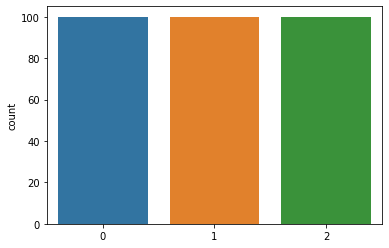

In [118]:
import seaborn as sns

_ = sns.countplot(Y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


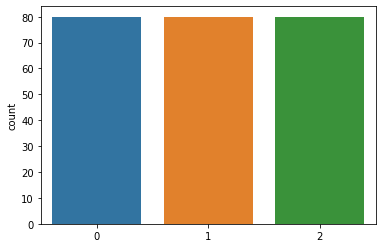

In [119]:
_ = sns.countplot(Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


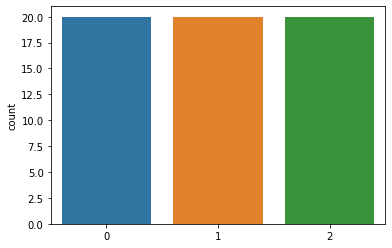

In [120]:
_ = sns.countplot(Y_test)

In [121]:
def load_image(path, file_name):
    im_path = path + file_name
    print(im_path)
    img = cv2.imread(im_path, cv2.IMREAD_COLOR)
    return img


/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (401).jpg


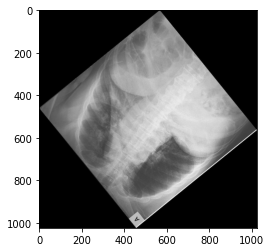

In [122]:
import matplotlib.pyplot as plt
im = load_image(DataProperties.covid_path, X[0])
plt.imshow(im)

In [123]:
r = cv2.resize(im, (500, 500))

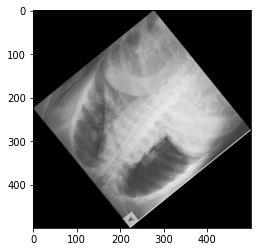

In [124]:
plt.imshow(r)

# Creating dataset

In [125]:
def resize_image(image, new_shape):
    n = cv2.resize(image, new_shape)
    return n

def normalize_image(image):
    return tf.cast(image, tf.float32) / 255.


def create_dataset(file_names, shuffle, cache_file):
    dataset = tf.data.Dataset.from_tensor_slices(
        file_names
    )

    # load image func
    load_im = lambda file_name: (
        tf.numpy_function(load_image, [file_name], tf.float32)
    )

    # resize
    resize_im = lambda image: (
        tf.numpy_function(
            resize_image, 
            [image, PreprocParameters.resize_shape], 
            tf.float32
        )
    )

    # normalize
    normalize_im = lambda image: (
        tf.numpy_function(
            normalize_image,
            [image],
            tf.float32
        )
    )

    dataset = dataset.map(load_im, num_parallel_calls = os.cpu_count())
    dataset = dataset.map(resize_im, num_parallel_calls = os.cpu_count())
    dataset = dataset.map(normalize_im, num_parallel_calls = os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(
        batch_size = TrainParameters.batch_size
    )

    # Prefetch
    dataset = dataset.prefetch(buffer_size = 1)

    return dataset

In [127]:
train_dataset = create_dataset(
    X_train,
    shuffle = True,
    cache_file = 'train_cache'
)

test_dataset = create_dataset(
    X_test,
    shuffle = True,
    cache_file = 'test_cache'
)

In [ ]:



def load_malaria_filenames(load_data_dir, labels, tot_images):
    X = []
    Y = []

    for l_idx, label in enumerate(labels):
        image_names = os.listdir(os.path.join(load_data_dir, label))

        for i, image_name in enumerate(image_names[:tot_images]):
            if not image_name.endswith('.png'):
                continue
            img_name = os.path.join(load_data_dir, label, image_name)
            X.append(img_name)
            Y.append(l_idx)

    print('Loading filenames completed.')

    return X, Y


def load_malaria_image(img_name):
    num_row = 100
    num_col = 100

    if isinstance(img_name, bytes):
        img_name = img_name.decode()

    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    img = np.array(cv2.resize(img, (num_row, num_col)), dtype='float32')

    return img


def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.